In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd
from bayes_opt import BayesianOptimization
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [3]:
# Load the Excel file
file_path = "/Users/justin/Downloads/output_sheets (1).xlsx"  # Update with file path
excel_data = pd.ExcelFile(file_path)

# Step 1: Load and preprocess data from all sheets
sheet_names = excel_data.sheet_names

In [4]:
# Define lists to store filtered data
filtered_X_data = []
filtered_y_data = []

# Loop through each sheet and check the number of rows
for sheet_name in excel_data.sheet_names:
    df = excel_data.parse(sheet_name)


    if len(df) >= 3:
        # Replace NaNs with zeros 
        df = df.fillna(0)

        constant_columns = ['dimension', 'horizon', 'number_of_vehicles', 'vehicle_capacity', 'supplier_coord_x',
                            'supplier_coord_y', 'supplier_start_level_inv', 'supplier_inv_cost',
                            'supplier_car_prod_cost', 'supplier_setup_prod_cost', 'supplier_prod_capacity', 'supplier_inv_capacity']
        target_columns = ['sol_obj', 'sol_x', 'sol_y', 'sol_gamma', 'sol_delta', 'sol_I_depot', 'sol_I']


        constant_values = df[constant_columns].iloc[0].values
         # Padding to fixed length 
        constant_values_repeated = np.tile(constant_values, (50, 1)) 
        variable_features = df.drop(columns=constant_columns + target_columns).values
        variable_features_padded = np.pad(variable_features, ((0, 50 - len(variable_features)), (0, 0)), mode='constant')
        combined_features = np.hstack([constant_values_repeated, variable_features_padded])
        filtered_X_data.append(combined_features)

        # Extract and pad target values for y_data
        target_values = df[target_columns].values
        target_values_padded = np.pad(target_values, ((0, 50 - len(target_values)), (0, 0)), mode='constant')
        filtered_y_data.append(target_values_padded)

# Convert to numpy arrays for further processing
X_data = np.array(filtered_X_data)
y_data = np.array(filtered_y_data)

print(f"Number of sheets considered: {len(X_data)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


Number of sheets considered: 26572


In [6]:
# Step 2: Define the model training function
def train_model(lr, num_units1, num_units2, num_units3, num_units4, num_units5, l2_rate):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Dense(int(num_units1), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(int(num_units2), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(int(num_units3), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(int(num_units4), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(int(num_units5), activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(y_train.shape[2])  # Output shape based on y_train columns
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    return -history.history['val_loss'][-1]

In [8]:
# Step 3: Define the bounds for Bayesian Optimization
pbounds = {
    'lr': (1e-6, 1e-1),
    'num_units1': (16, 256),
    'num_units2': (16, 128),
    'num_units3': (16, 128),
    'num_units4': (16, 128),
    'num_units5': (16, 128),
    'l2_rate': (0.01, 0.5)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=train_model, pbounds=pbounds, random_state=42, verbose=2)
optimizer.maximize(init_points=10, n_iter=100)

# Extract best parameters from Bayesian Optimization
best_params = optimizer.max['params']
best_params = {key: int(val) if 'num_units' in key else float(val) for key, val in best_params.items()}
print("Best parameters found: ", best_params)


|   iter    |  target   |  l2_rate  |    lr     | num_un... | num_un... | num_un... | num_un... | num_un... |
-------------------------------------------------------------------------------------------------------------
| 1         | -5.23e+07 | 0.1935    | 0.09507   | 191.7     | 83.05     | 33.47     | 33.47     | 22.51     |
| 2         | -4.504e+0 | 0.4344    | 0.06011   | 185.9     | 18.31     | 124.6     | 109.2     | 39.78     |
| 3         | -5.74e+07 | 0.09909   | 0.01834   | 89.02     | 74.77     | 64.38     | 48.62     | 84.53     |
| 4         | -2.712e+0 | 0.07835   | 0.02922   | 103.9     | 67.08     | 103.9     | 38.36     | 73.59     |
| 5         | -5.306e+0 | 0.3003    | 0.004646  | 161.8     | 35.1      | 23.29     | 122.3     | 124.2     |
| 6         | -6.408e+0 | 0.4061    | 0.03046   | 39.44     | 92.63     | 65.3      | 29.67     | 71.46     |
| 7         | -5.169e+0 | 0.02685   | 0.09093   | 78.11     | 90.2      | 50.91     | 74.25     | 77.23     |
| 8       

In [9]:
# Step 4: Train Final Model with Best Parameters
higher_l2_rate = 0.1  

final_model = Sequential([
    Dense(best_params['num_units1'], activation='relu', kernel_regularizer=l2(higher_l2_rate), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    Dense(best_params['num_units2'], activation='relu', kernel_regularizer=l2(higher_l2_rate)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(best_params['num_units3'], activation='relu', kernel_regularizer=l2(higher_l2_rate)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(best_params['num_units4'], activation='relu', kernel_regularizer=l2(higher_l2_rate)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(best_params['num_units5'], activation='relu', kernel_regularizer=l2(higher_l2_rate)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(y_train.shape[2])
])

final_model.compile(optimizer=Adam(learning_rate=best_params['lr'], clipvalue=0.5), loss='mean_squared_error', metrics=['mae'])

history = final_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    ]
)

# Evaluate the final model
test_loss, test_mae = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 61056208.0000 - mae: 384.1541 - val_loss: 61963896.0000 - val_mae: 409.0226 - learning_rate: 0.0181
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 59056704.0000 - mae: 506.8823 - val_loss: 61039676.0000 - val_mae: 607.9783 - learning_rate: 0.0181
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 55766464.0000 - mae: 699.1344 - val_loss: 60425924.0000 - val_mae: 514.2109 - learning_rate: 0.0181
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 52701400.0000 - mae: 657.0296 - val_loss: 61177776.0000 - val_mae: 568.9561 - learning_rate: 0.0181
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 49658108.0000 - mae: 620.0326 - val_loss: 48945976.0000 - val_mae: 659.3646 - learning_rate: 0.0181
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 48139044.0000 - mae: 597.0930 - val_loss: 64690852.0000 - val_mae: 973.6068 - learning_rate: 0.0181
Epoch 7/100
133/133 ━━━━━━━━

In [106]:
final_model.summary()

Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1284 (Dense)              │ (None, 50, 27)         │           567 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1070        │ (None, 50, 27)         │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1070 (Dropout)          │ (None, 50, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1285 (Dense)              │ (None, 50, 48)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1071        │ (None, 50, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1071 (Dropout)          │ (None, 50, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1286 (Dense)              │ (None, 50, 65)         │         3,185 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1072        │ (None, 50, 65)         │           260 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1072 (Dropout)          │ (None, 50, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1287 (Dense)              │ (None, 50, 46)         │         3,036 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1073        │ (None, 50, 46)         │           184 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1073 (Dropout)          │ (None, 50, 46)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1288 (Dense)              │ (None, 50, 113)        │         5,311 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1074        │ (None, 50, 113)        │           452 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1074 (Dropout)          │ (None, 50, 113)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1289 (Dense)              │ (None, 50, 7)          │           798 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,117 (176.24 KB)

 Trainable params: 14,839 (57.96 KB)

 Non-trainable params: 598 (2.34 KB)

 Optimizer params: 29,680 (115.94 KB)

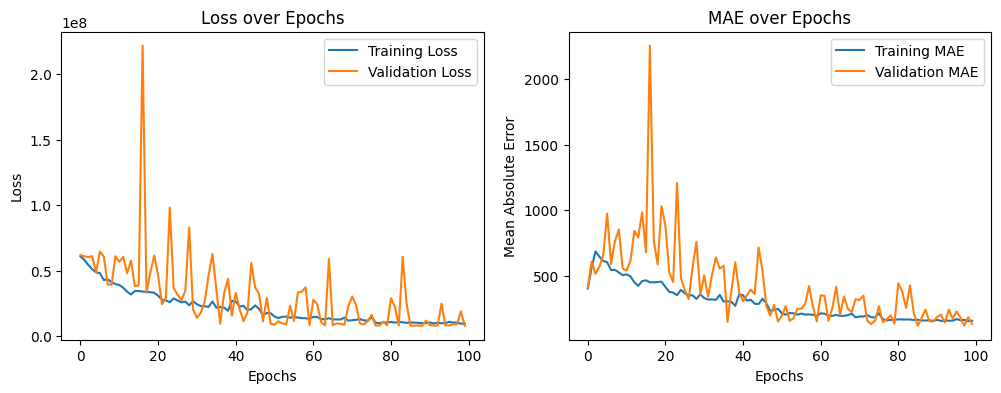

In [99]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()


In [98]:
#Save the model and weights 

final_model.save("Last_NN_GP.h5")
final_model.save_weights("Last_NN_GP.weights.h5")

import pickle

with open("Last_NN_GP_best_params.pkl", "wb") as file:
    pickle.dump(best_params, file)

